In [1]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
from string import ascii_lowercase
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.layers import concatenate, Reshape, Conv2D, MaxPool2D, Flatten, Dropout, SpatialDropout1D
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Preprocess

In [10]:
def preprocess(data):
    data = data.lower()
    special_characters = '.,!#$%&*"?|\/”“+'

    #convert abbreviations      
    with open('teencode.txt','r') as file:
      file = file.read()
      lines = file.split('\n')
      for line in lines:
        elements = line.split('\t')
        data = re.sub(r'\b{}\b'.format(elements[0]), elements[1], data)
    
    #convert string: hayyyy -> hay
    for c in ascii_lowercase:
        data = re.sub(r'{}+'.format(c), c, data)
      
    # remove symbols
    for char in special_characters:
        data = re.sub(r'{}+'.format(re.escape(char)), ' ', data)
    data = re.sub(r'\s+', ' ', data)
    return data


In [11]:
df = pd.read_csv('reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16087 entries, 0 to 16086
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16087 non-null  int64 
 1   text        16087 non-null  object
 2   label       16087 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 377.2+ KB


In [12]:

df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

,text,label
0,Dung dc sp tot cam on shop Đóng gói sản phẩm ...,0
1,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1
...,...,...
16082,Chẳng biết là Shop có biết đọc hay không mua ố...,1
16083,Cuốn này mỏng. Đọc một buổi sáng là hết. Thú t...,1
16084,Mang êm chân. Đẹp,0
16085,Tôi đã nhận đc hàng.Sau đây là vài lời muốn nó...,1


In [13]:
df['text'] = df['text'].apply(preprocess)
df

,text,label
0,dung được sp tot cam on shop đóng gói sản phẩm...,0
1,chất lượng sản phẩm tuyệt vời son mịn nhưng k...,0
2,chất lượng sản phẩm tuyệt vời nhưng không có ...,0
3,:(( mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,lần trước mình mua áo gió màu hồng rất ok mà đ...,1
...,...,...
16082,chẳng biết là shop có biết đọc hay không mua ố...,1
16083,cuốn này mỏng đọc một buổi sáng là hết thú thậ...,1
16084,mang êm chân đẹp,0
16085,tôi đã nhận được hàng sau đây là vài lời muốn ...,1


<Axes: xlabel='label', ylabel='count'>

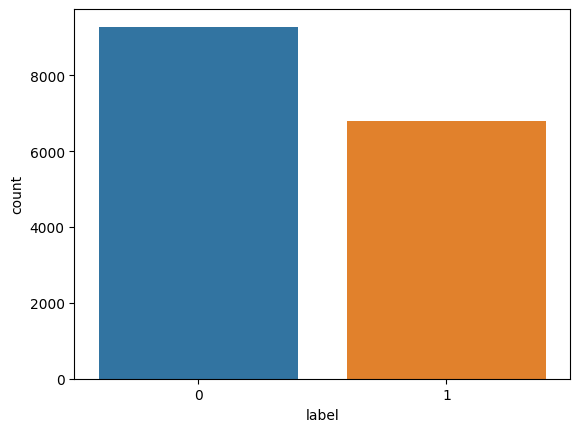

In [ ]:
#0: tích cực   1:tiêu cực
sns.countplot(x=df["label"])


<Axes: xlabel='length', ylabel='Count'>

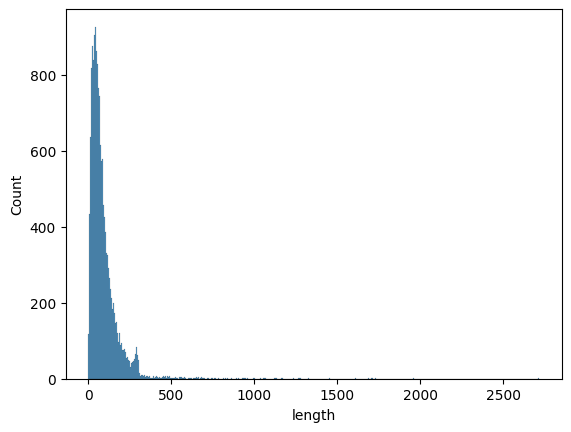

In [ ]:
list_len_texs = [len(i) for i in df['text']]
plt.xlabel('length')
sns.histplot( x=list_len_texs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['label'],train_size = 0.85,random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,train_size = 0.8,random_state=42)

In [ ]:
X_train.shape,X_test.shape,X_valid.shape

((10938,), (2414,), (2735,))

In [ ]:
tokenizer = text.Tokenizer(num_words=10000, lower=True)
tokenizer.fit_on_texts(X_train.astype(str))

In [ ]:
maxlen = 1000
X_train_fold = [str(p) for p in list(X_train)]
X_train_fold = tokenizer.texts_to_sequences(X_train_fold)
X_train_fold = pad_sequences(X_train_fold, maxlen=maxlen)

X_test_fold = [str(p) for p in list(X_test)]
X_test_fold = tokenizer.texts_to_sequences(X_test_fold)
X_test_fold = pad_sequences(X_test_fold, maxlen=maxlen)

X_valid_fold = [str(p) for p in list(X_valid)]
X_valid_fold = tokenizer.texts_to_sequences(X_valid_fold)
X_valid_fold = pad_sequences(X_valid_fold, maxlen=maxlen)


# RandomForest

In [ ]:
param_grid_rand = {
    'n_estimators': [100, 200, 500,1000],
    'min_samples_split': [2, 5, 10,15],
}
clf_rand = RandomForestClassifier()

clf_rand = GridSearchCV(clf_rand, param_grid=param_grid_rand, cv=5, n_jobs=-1)
clf_rand.fit(X_train_fold, y_train)


print("Best hyperparameters: ", clf_rand.best_params_)

Best hyperparameters:  {'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
# test
y_pred_test_rand = clf_rand.predict(X_test_fold)

print(classification_report(y_test, y_pred_test_rand, digits = 4))

              precision    recall  f1-score   support

           0     0.7495    0.8079    0.7776      1400
           1     0.7028    0.6272    0.6628      1014

    accuracy                         0.7320      2414
   macro avg     0.7261    0.7175    0.7202      2414
weighted avg     0.7299    0.7320    0.7294      2414



In [ ]:
# valid
y_pred_valid_rand = clf_rand.predict(X_valid_fold)

print(classification_report(y_valid, y_pred_valid_rand, digits = 4))

              precision    recall  f1-score   support

           0     0.7641    0.7893    0.7765      1547
           1     0.7133    0.6827    0.6976      1188

    accuracy                         0.7430      2735
   macro avg     0.7387    0.7360    0.7371      2735
weighted avg     0.7420    0.7430    0.7422      2735



# XGBoost

In [ ]:
param_grid_xgb = {
    'max_depth': [5, 7, 9],
    'n_estimators': [200,500, 1000]
}

clf_xgb = XGBClassifier()
grid_search = GridSearchCV(clf_xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1)

grid_search.fit(X_train_fold, y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 5, 'n_estimators': 500}


In [ ]:
# test
y_pred_test_xgb = clf_xgb.predict(X_test_fold)
print(classification_report(y_test, y_pred_test_xgb, digits = 4))

              precision    recall  f1-score   support

           0     0.8275    0.8293    0.8284      1400
           1     0.7636    0.7613    0.7625      1014

    accuracy                         0.8007      2414
   macro avg     0.7956    0.7953    0.7954      2414
weighted avg     0.8007    0.8007    0.8007      2414



In [ ]:
# valid
y_pred_valid_xgb = clf_xgb.predict(X_valid_fold)
print(classification_report(y_valid, y_pred_valid_xgb, digits = 4))

              precision    recall  f1-score   support

           0     0.8283    0.8106    0.8193      1547
           1     0.7600    0.7811    0.7704      1188

    accuracy                         0.7978      2735
   macro avg     0.7942    0.7959    0.7949      2735
weighted avg     0.7986    0.7978    0.7981      2735



# CNN + WORD EMBEDDING

In [ ]:
embeddings_index ={}

#Dowload cc.vi.300 at: https://fasttext.cc/docs/en/crawl-vectors.html
with open('cc.vi.300.vec', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs



In [ ]:
max_features = 3000
embed_size = 300
batch_size = 1024
epochs = 10

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embed_size))
max_features = num_words

for word, i in word_index.items():
    if i >= max_features:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:


filter_sizes = [1,2,3,5]
num_filters = 32

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights =[embedding_matrix])(inp)
x = SpatialDropout1D(0.4)(x)
x = Reshape((maxlen, embed_size, 1))(x)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',
                activation='elu' , name='conv_0')(x)
maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1),name='pool_0')(conv_0)


conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',
                activation='elu', name='conv_1')(x)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1),name='pool_1')(conv_1)


conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',
                activation='elu', name='conv_2')(x)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1),name='pool_2')(conv_2)


conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), kernel_initializer='normal',
                activation='elu', name='conv_3')(x)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1),name='pool_3')(conv_3)

z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
z = Flatten()(z)
z = Dropout(0.4)(z)

outp = Dense(2, activation="softmax")(z)

optimizer = Adam(beta_1=0.9, beta_2=0.999)

loss = CategoricalCrossentropy()

model = Model(inputs=inp, outputs=outp)
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 300)    2375100     ['input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 1000, 300)   0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 reshape_3 (Reshape)            (None, 1000, 300, 1  0           ['spatial_dropout1d_3[0][0]']

In [ ]:
to_y_train = to_categorical(y_train, num_classes=2)
to_y_valid = to_categorical(y_valid, num_classes=2)

callback = EarlyStopping(patience=3) 
model.fit(x=X_train_fold, y=to_y_train, validation_data=(X_valid_fold, to_y_valid), batch_size=64, epochs=10, verbose=1, callbacks= [callback])

Epoch 1/10
171/171 [==============================] - 206s 651ms/step - loss: 0.4040 - categorical_accuracy: 0.8126 - val_loss: 0.2647 - val_categorical_accuracy: 0.8925
Epoch 2/10
171/171 [==============================] - 22s 130ms/step - loss: 0.2539 - categorical_accuracy: 0.9025 - val_loss: 0.2460 - val_categorical_accuracy: 0.9009
Epoch 3/10
171/171 [==============================] - 14s 83ms/step - loss: 0.2087 - categorical_accuracy: 0.9205 - val_loss: 0.2471 - val_categorical_accuracy: 0.9002
Epoch 4/10
171/171 [==============================] - 12s 72ms/step - loss: 0.1767 - categorical_accuracy: 0.9345 - val_loss: 0.2605 - val_categorical_accuracy: 0.8984
Epoch 5/10
171/171 [==============================] - 12s 72ms/step - loss: 0.1472 - categorical_accuracy: 0.9470 - val_loss: 0.2594 - val_categorical_accuracy: 0.9031


In [ ]:
prediction = model.predict(X_test_fold, batch_size=batch_size, verbose=1)
y_pred_test_cnn = prediction.argmax(axis=-1)

print(classification_report(y_test, y_pred_test_cnn,digits=4)) 

3/3 [==============================] - 12s 2s/step
              precision    recall  f1-score   support

           0     0.9203    0.9079    0.9141      1400
           1     0.8751    0.8915    0.8832      1014

    accuracy                         0.9010      2414
   macro avg     0.8977    0.8997    0.8987      2414
weighted avg     0.9014    0.9010    0.9011      2414



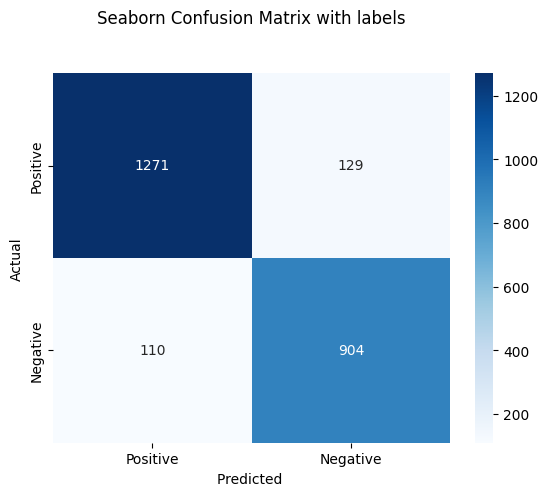

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
confuse = confusion_matrix(y_test, y_pred_test_cnn, labels=[0, 1])



ax = sns.heatmap(confuse, fmt="", annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

plt.show()

In [ ]:
prediction = model.predict(X_valid_fold, batch_size=batch_size, verbose=1)
y_pred_valid_cnn = prediction.argmax(axis=-1)

print(classification_report(y_valid, y_pred_valid_cnn,digits=4)) 

3/3 [==============================] - 1s 300ms/step
              precision    recall  f1-score   support

           0     0.9212    0.9063    0.9137      1547
           1     0.8805    0.8990    0.8896      1188

    accuracy                         0.9031      2735
   macro avg     0.9008    0.9026    0.9016      2735
weighted avg     0.9035    0.9031    0.9032      2735



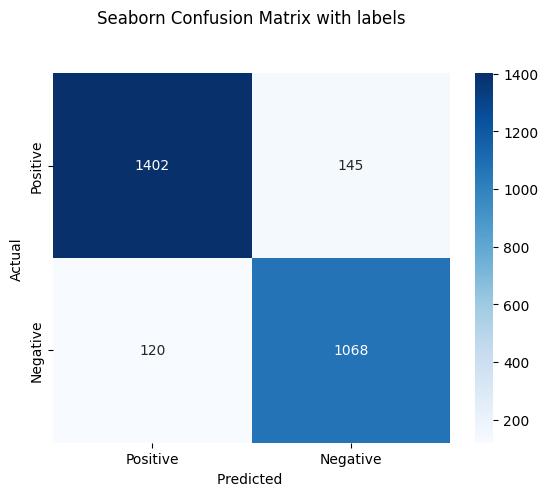

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
confuse = confusion_matrix(y_valid, y_pred_valid_cnn, labels=[0, 1])



ax = sns.heatmap(confuse, fmt="", annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])

plt.show()